In [54]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [55]:
device = 'cpu'
ticker = 'AAPL'
df = yf.download(ticker, "2020-01-07")

[*********************100%***********************]  1 of 1 completed


In [56]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-07,71.995346,72.600952,71.775781,72.345197,108872000
2020-01-08,73.153481,73.455080,71.698566,71.698566,132079200
2020-01-09,74.707367,74.900388,73.879780,74.130705,170108400
2020-01-10,74.876236,75.440836,74.374378,74.941386,140644800
2020-01-13,76.475922,76.502466,75.074089,75.192321,121532000
...,...,...,...,...,...
2026-01-05,267.260010,271.510010,266.140015,270.640015,45647200
2026-01-06,262.359985,267.549988,262.119995,267.000000,52352100


<Axes: xlabel='Date'>

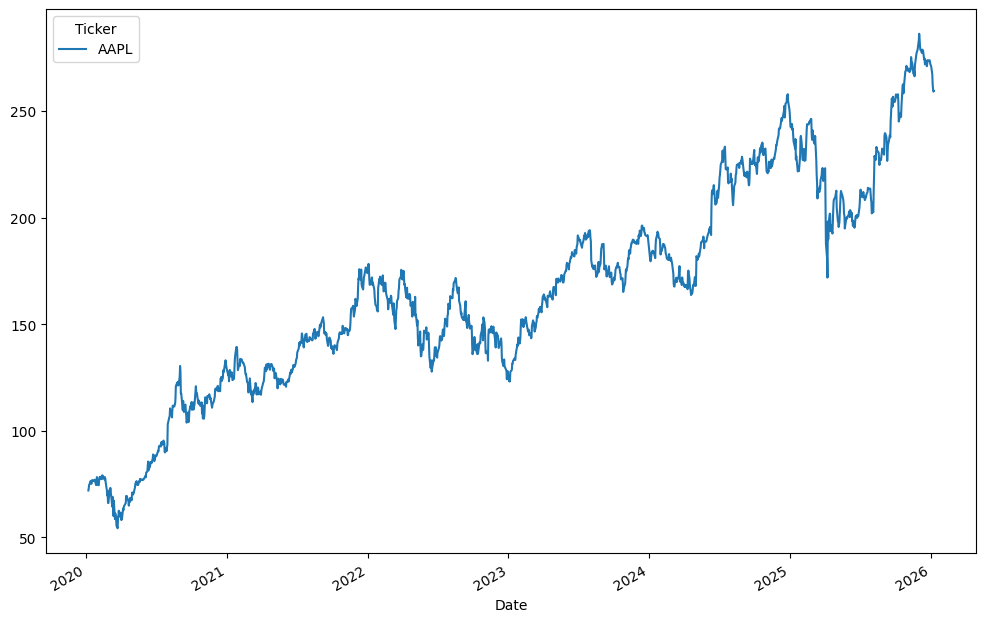

In [57]:
df.Close.plot(figsize=(12,8))

In [58]:
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df['Close'])
df.Close

Ticker,AAPL
Date,
2020-01-07,-1.875512
2020-01-08,-1.852287
2020-01-09,-1.821124
2020-01-10,-1.817738
2020-01-13,-1.785657
...,...
2026-01-05,2.040425
2026-01-06,1.942157
2026-01-07,1.901446


In [59]:
seq_length = 30
data = []

for i in range (len(df) - seq_length):
    data.append(
        df.Close[i:i+seq_length].values.reshape(-1, 1)
    )


data = np.array(data)
train_size = int(0.8*len(data))
print(data.shape)



(1481, 30, 1)


In [60]:

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [61]:
class PredictionModel(nn.Module):

    def  __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:,-1,:])

        return out

In [62]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [63]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [64]:
num_epochs=1000

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.6246257424354553
25 0.015815412625670433
50 0.005767653230577707
75 0.004867722745984793
100 0.004516480956226587
125 0.004233750980347395
150 0.003973160404711962
175 0.0037339788395911455
200 0.003520000260323286
225 0.0033349506556987762
250 0.003179035382345319
275 0.003049554768949747
300 0.002950231544673443
325 0.0035135033540427685
350 0.0030288961715996265
375 0.0028926609084010124
400 0.0028640918899327517
425 0.0028555237222462893
450 0.0028518387116491795
475 0.002849271520972252
500 0.002847174648195505
525 0.0028453804552555084
550 0.0028437920846045017
575 0.002842345042154193
600 0.0028409946244210005
625 0.002839708002284169
650 0.002838460262864828
675 0.002837233943864703
700 0.002836016472429037
725 0.0028347994666546583
750 0.002833583392202854
775 0.0028323717415332794
800 0.002831174060702324
825 0.0028300003614276648
850 0.0028288597241044044
875 0.0028277572710067034
900 0.0028266895096749067
925 0.0028256496880203485
950 0.0028246259316802025
975 0.0028236

In [65]:
model.eval()

y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

In [66]:
train_rmse = root_mean_squared_error(y_train[:,0], y_train_pred[:,0])
test_rmse = root_mean_squared_error(y_test[:,0], y_test_pred[:,0])

In [67]:
train_rmse

2.6492011547088623

In [68]:
test_rmse

7.288710117340088

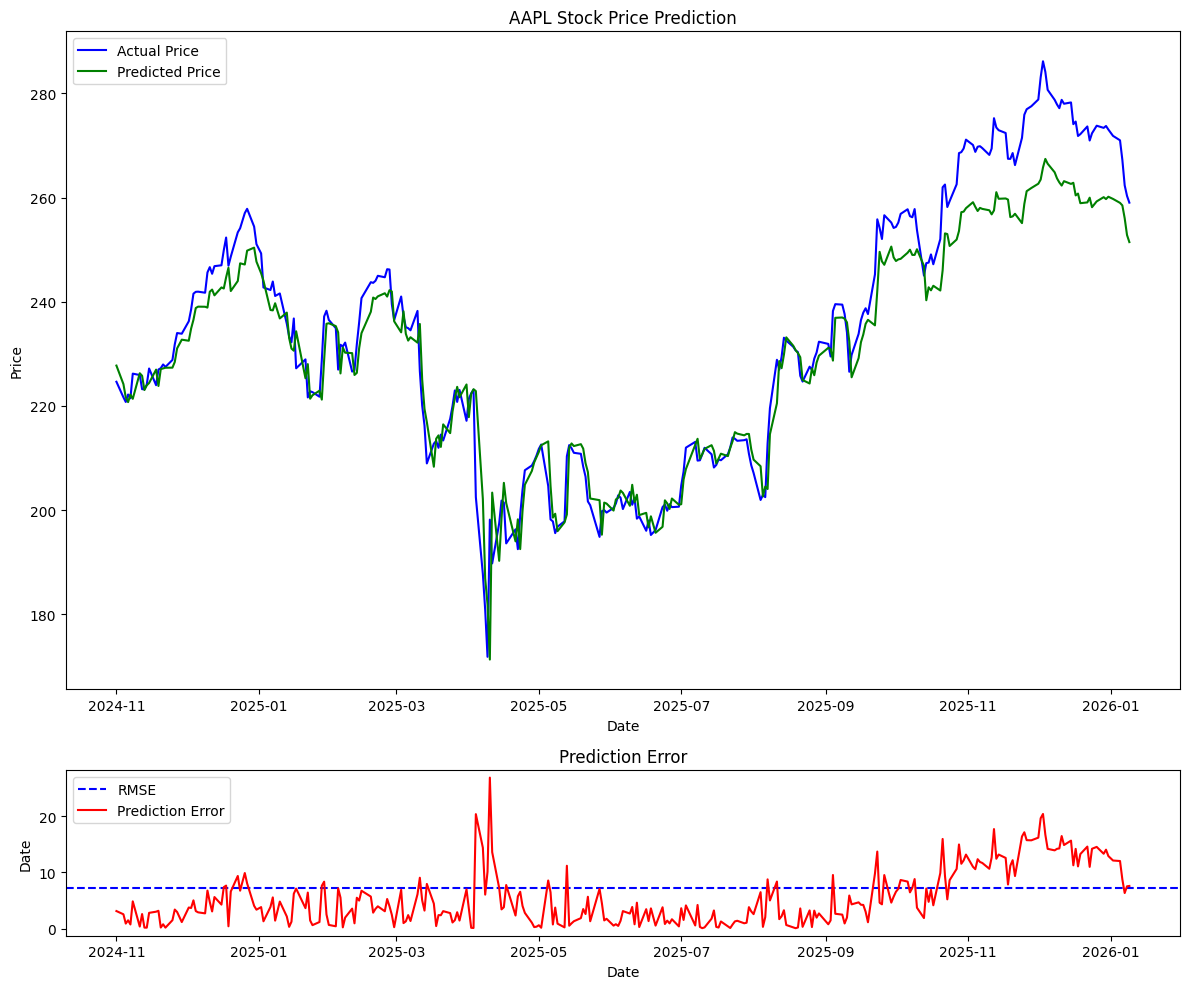

In [69]:
fig = plt.figure(figsize=(12,10))

gs = fig.add_gridspec(4,1)

ax1 = fig.add_subplot (gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'green', label = 'Predicted Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

ax2=fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color = 'blue', linestyle='--', label = 'RMSE')
ax2.plot (df[-len(y_test) : ].index, abs(y_test - y_test_pred), 'r', label = 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Date')


plt.tight_layout()
plt.show()

In [70]:

bundle = {
    'model_state': model.state_dict(),
    'scaler': scaler,
    'config': {
        'input_dim': 1,
        'hidden_dim': 32,
        'num_layers': 2,
        'output_dim': 1
    }
}

torch.save(bundle, 'full_pipeline.pth')